# To be used with gyst2D

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import argparse
from scipy import interpolate
import tqdm
import nmmn.lsd, nmmn.misc
import os.path
import pandas as pd
import astropy.visualization

In [3]:
# Constants, definitions and units

# many are related to grmonty, but we can set a black hole mass if we want to have a "feeling" for the physical values

global MP, ME, CL, GNEWT, KBOL, SIGMA_THOMSON, MSUN, LSUN, YEAR, MBH
global TPTE_DISK, TPTE_JET, THETAE_MAX
global M_unit, L_unit, T_unit, RHO_unit, U_unit, B_unit, Ne_unit

# all constants in cgs units
ME = 9.1093826e-28 # electron mass
MP = 1.67262171e-24 # proton mass
CL = 2.99792458e10 # speed of light
GNEWT = 6.6742e-8 # gravitational constant
KBOL = 1.3806505e-16 # Boltzmann constant
SIGMA_THOMSON = 0.665245873e-24 # Thomson cross-section
MSUN = 1.989e33 # solar mass
LSUN = 3.827e33 # solar luminosity
YEAR = 31536000 # seconds in a year

# temperature and beta-prescription (Mościbrodzka 2016)
TPTE_DISK = 20. # R_high
TPTE_JET = 1. # R_low
THETAE_MAX = 1000.
TP_OVER_TE = 100.0

# grmonty units and BH mass
MBH = 4.5e6 * MSUN # Sgr A*
#MBH = 6.2e9 * MSUN # M87
#MBH = 5.0e9 * MSUN
#MBH = 10.0 * MSUN
M_unit = 1.0e19
#M_unit = 2.0*10e11
L_unit = GNEWT * MBH / (CL * CL)
T_unit = L_unit / CL
RHO_unit = M_unit / (L_unit*L_unit*L_unit)
U_unit = RHO_unit * CL * CL
B_unit = CL * np.sqrt(4. * np.pi * RHO_unit)
Ne_unit = RHO_unit / (MP + ME)

## Read dump files

In [4]:
%run -i harm_script2.py

In [5]:
rg("gdump")

In [6]:
rd("dump458")

harm_script2.py:738: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)


In [7]:
N1, N2, N3 = nx, ny, nz

sigma = bsq/rho
sigmaphi = bu[3]*bd[3]/(rho)

betapl = 2.0*pg/bsq

bphi = bu[3]*B_unit
Bphi = B[3]*B_unit
#jcurr = np.nan_to_num(jcurr)
jdotu = mdot(ju,ud)
Jsq = jsq + jdotu*jdotu
gJsq = gdet*Jsq
JJJ = sqrt(Jsq)

EF = rho + gam*ug
EE = bsq + EF
va2 = bsq/EE
va = np.sqrt(va2)

enth=1+ug*gam/rho
unb=enth*ud[0]
isunbound=(-unb>1.02)

In [8]:
Jfile = "/work/gustavo/gyst/jcs_files/dump458_jcs"
#Jfilepeak = "/home/gustavo/work/gyst/jcs_files/dump400_jcs_peak"
Jfilechar = "/work/gustavo/gyst/jcs_files/dump458_jcs_char"

f1 = open(Jfile, "rb")
dtype = np.float64
body = np.fromfile(f1,dtype=dtype,count=-1)
JJ_cs = body.view().reshape((int(N1),int(N2),int(N3)), order='C')

"""
f2 = open(Jfilepeak, "rb")
dtype = np.float64
body = np.fromfile(f2,dtype=dtype,count=-1)
JJ_cs_peak = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
"""

f3 = open(Jfilechar, "rb")
dtype = np.float64
body = np.fromfile(f3,dtype=dtype,count=-1)
JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')

JJ_cs_char_ind = numpy.zeros(shape=(N1,N2,N3))
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            if JJ_cs_char[i][j][k] > 0:
                JJ_cs_char_ind[i][j][k] = 1
                
#Jdata = np.loadtxt(Jfile)
#JJ_cs = np.reshape(Jdata, (int(N1), int(N2), int(N3)))

rx = []
ry = []
for i in range(525):
    for j in range(N2):
        for k in range(N3):
            if (JJ_cs_char_ind[i][j][k] == 1):
                rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                ry.append(r[i][j][k] * np.cos(h[i][j][k]))

In [9]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

## Make a few test plots

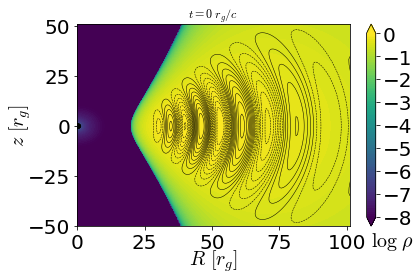

In [170]:
mirror = 1
if(mirror):
    xmax = 100
    ymax = xmax/2
    step = xmax/4
else:
    xmax = 125
    ymax = 250
    step = 25





hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(rho),levels = np.linspace(-8, 0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\rho$",fontsize=20,ha="left")
cb.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(-ymax,ymax+1)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho.png", dpi = 300)

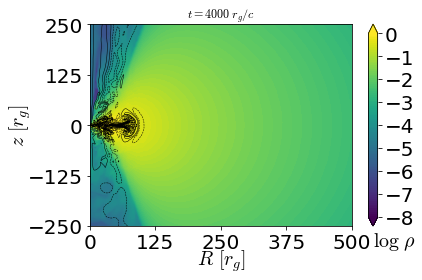

In [44]:
mirror = 1
if(mirror):
    xmax = 500
    ymax = xmax/2
    step = xmax/4
else:
    xmax = 100
    ymax = 0
    xmin = 0
    ymin = -xmax
    step = 25

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(rho),levels = np.linspace(-8, 0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\rho$",fontsize=20,ha="left")
cb.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(-ymax,ymax+1)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
plc(aphi,levels=np.linspace(-amax,amax,10)[1:-1],colors="black",linewidths=0.5,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho_large.png", dpi = 300)

harm_script2.py:8: RuntimeWarning: divide by zero encountered in log10
  from matplotlib import rc
harm_script2.py:8: RuntimeWarning: invalid value encountered in log10
  from matplotlib import rc


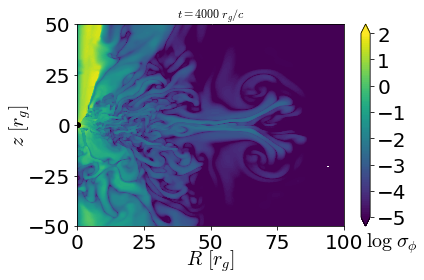

In [19]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(sigmaphi),levels = np.linspace(-5, 2, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\sigma_\phi$",fontsize=20,ha="left")
cb.set_ticks([-5,-4,-3,-2,-1,0,1,2])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("sigmaphi.png", dpi = 300)

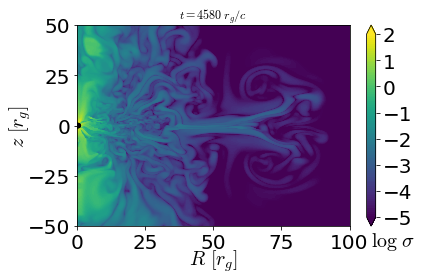

In [57]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(sigma),levels = np.linspace(-5, 2, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\sigma$",fontsize=20,ha="left")
cb.set_ticks([-5,-4,-3,-2,-1,0,1,2])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("sigma_2D_"+str(int(np.round(t)))+".png", dpi = 150)

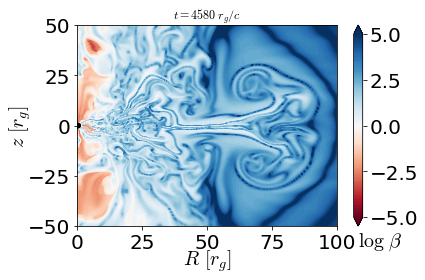

In [59]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(betapl), levels = np.linspace(-5, 5, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\beta$",fontsize=20,ha="left")
cb.set_ticks([-5,-2.5,0,2.5,5])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("beta_2D_"+str(int(np.round(t)))+".png", dpi = 150)

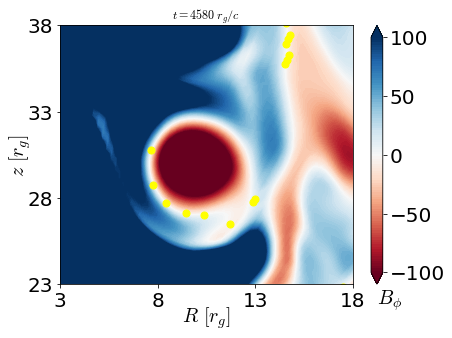

In [61]:
mirror = 0
if(mirror):
    xmax = 50
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 3
    xmax = 18
    ymin = 23
    ymax = 38
    step = 5

fig = plt.figure(figsize=[6.4, 4.8])
hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(Bphi*B_unit, levels = np.linspace(-100, 100, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
cb.set_ticks([-100,-50,0,50,100])
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 50)#, markersize = 0.01)
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("zoom_Bphi_2D_"+str(int(np.round(t)))+".png", dpi = 150)

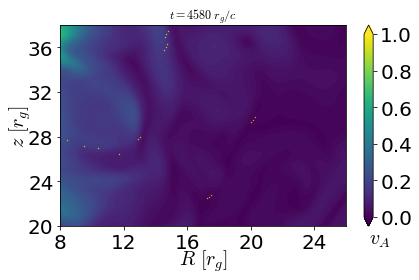

In [47]:
mirror = 0
if(mirror):
    xmax = 50
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    ymin = 20
    xmin = 8
    xmax = 25
    ymax = 37
    step = 4
    

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(va, levels = np.linspace(0, 1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$v_A$",fontsize=20,ha="left")
cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

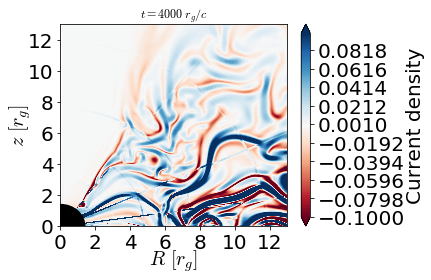

In [19]:
mirror = 0
if(mirror):
    xmax = 50
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmax = 12
    ymax = 12
    xmin = 0
    ymin = 0
    step = 2


#cs, cb = plco(jcurr/jcurr.max(), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(jd[3], levels=np.linspace(-10e-2,10e-2,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
#cb.set_ticks([0,0.02,0.04,0.06,0.08,0.01])
#cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("sheets_4000.png", format = "png", dpi = 300)
#plt.clf

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


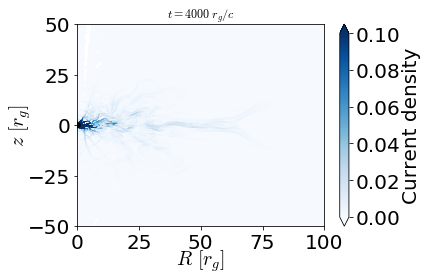

In [32]:
xmax = 100
ymax = xmax/2
step = xmax/4

#cs, cb = plco(jcurr/jcurr.max(), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(jcurr, levels=np.linspace(0,10e-2,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
#cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
plt.xticks(np.arange(0, xmax+1, step = step))
plt.yticks(np.arange(-ymax, ymax+1, step = step))
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("sheets_4000.png", format = "png", dpi = 300)
#plt.clf

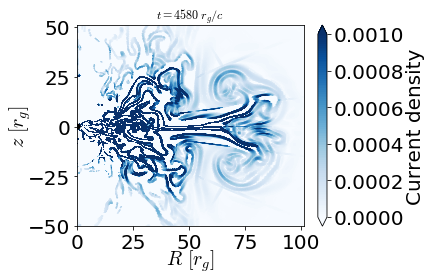

In [61]:
mirror = 1
if(mirror):
    xmax = 100
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 0
    xmax = 150
    ymin = -250
    ymax = -100
    step = 50

#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(JJ_cs, levels=np.linspace(0,10e-4,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-5,0,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)

#plot([rgx[yc]], [rgy[xc]], color='xkcd:aubergine', marker = 'o', markersize = 0.5)
#plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

#cb.ax.set_xlabel(r"$\log\;J$",fontsize=20,ha="left")
#cb.ax.set_xlabel(r"$J$",fontsize=20,ha="left")
#cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.set_ticks([0,0.0002,0.0004,0.0006,0.0008,0.001])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color = 'black')
fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("sheets_2D_"+str(int(np.round(t)))+".png", dpi = 150)
#plt.clf

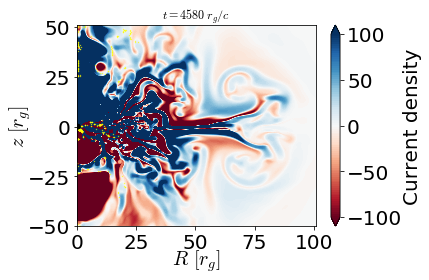

In [62]:
mirror = 1
if(mirror):
    xmax = 100
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 0
    xmax = 150
    ymin = -250
    ymax = -100
    step = 50

#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(Bphi*B_unit, levels = np.linspace(-100, 100, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-5,0,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)

#plot([rgx[yc]], [rgy[xc]], color='xkcd:aubergine', marker = 'o', markersize = 0.5)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

#cb.ax.set_xlabel(r"$\log\;J$",fontsize=20,ha="left")
#cb.ax.set_xlabel(r"$J$",fontsize=20,ha="left")
#cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.set_ticks([-100,-50,0,50,100])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color = 'black')
fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("Bphi_2D_sites_VA_jet_"+str(int(np.round(t)))+".png", dpi = 150)
#plt.clf

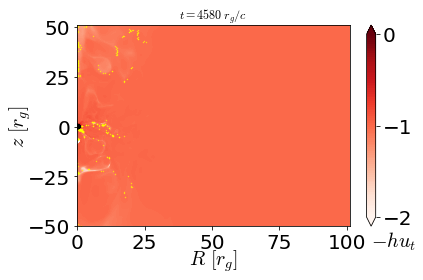

In [75]:
mirror = 1
if(mirror):
    xmax = 100
    ymax = xmax/2
    step = xmax/4
else:
    xmax = 125
    ymax = 250
    step = 25


hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(unb,levels = np.linspace(-2,0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'Reds')
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$-hu_t$",fontsize=20,ha="left")
cb.set_ticks([-2,-1,0])
if(mirror):
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(-ymax,ymax+1)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("bernoulli_2D_VA_jet.png", dpi = 150)

In [ ]:
xmax = 20
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(Bphi, levels = np.linspace(-2., 2., 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
cb.set_ticks([-2.0,-1.,0,1.,2.0])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

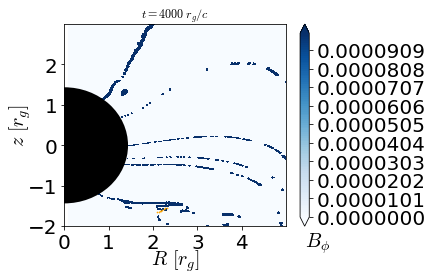

In [17]:
icord = [408,409,411,413,415,416,418,419]
jcord = [113,112,111,110,110,109,109,107]

rxx = []
ryy = []

for i in range(len(icord)):
    rxx.append(r[jcord[i]][icord[i]][0] * np.sin(h[jcord[i]][icord[i]][0]))
    ryy.append(r[jcord[i]][icord[i]][0] * np.cos(h[jcord[i]][icord[i]][0]))
    
#testi = [333, 350, 361, 389, 791]
#testj = [57, 146, 103, 199, 477]
testi = [109]
testj= [58]
testx = []
testy = []
for i in range(len(testi)):
    testx.append(r[testi[i]][testj[i]][0] * np.sin(h[testi[i]][testj[i]][0]))
    testy.append(r[testi[i]][testj[i]][0] * np.cos(h[testi[i]][testj[i]][0]))


mirror = 1
if(mirror):
    xmax = 4
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmax = 5
    ymax = -10
    xmin = 0
    ymin = -15
    step = 5

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()

#cs, cb = plco(Bphi, levels = np.linspace(-1, 1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
cs, cb = plco(JJ_cs_char, levels=np.linspace(0,10e-5,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')

#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

#plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)
plt.scatter(rxx, ryy, c ='orange', marker = 'o', s = 0.5)#, markersize = 0.01)
#plt.scatter(testx, testy, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

## Characterization of current sheets

In [ ]:
hdeg = degrees(h[0])
hfont = {'fontname':'Helvetica'}
plt.plot(hdeg,sigma[55], label = r'$r = 5\;r_g$', color = 'black')
plt.plot(hdeg,sigma[83], label = r'$r = 10\;r_g$', color='green')
plt.plot(hdeg,sigma[99], label = r'$r = 15\;r_g$', color ='blue')
plt.plot(hdeg,sigma[110], label = r'$r = 20\;r_g$', color='yellow')
plt.yscale('log')
plt.xlabel(r'$\theta\;(deg)$')
plt.ylabel(r'$\sigma$')
plt.xticks(np.arange(0, 181, step=30)) #GS
#plt.yticks(np.arange(49, 50, step=10)) #GS
plt.legend()
plt.tight_layout() # GS
#plt.savefig("/work/gustavo/2ds9/harmpi-master/current_sheets/sigma_radius.png", dpi = 200)


## Current sheets

In [5]:
imin = 200
imax = 205
for i in range(imin,imax):
    
    myfilename = "/home/gustavo/work/dumps2D/dump%03d" %(i)
    rd(myfilename)
    N1, N2, N3 = nx, ny, nz
    sigma = bsq/rho
    sigmaphi = bu[3]*bd[3]/(rho)
    betapl = 2.0*pg/bsq
    bphi = bu[3]*B_unit
    Bphi = B[3]*B_unit
    #jcurr = np.nan_to_num(jcurr)
    jdotu = mdot(ju,ud)
    Jsq = jsq + jdotu*jdotu
    gJsq = gdet*Jsq
    JJJ = sqrt(Jsq)
    EF = rho + gam*ug
    EE = bsq + EF
    va2 = bsq/EE
    va = np.sqrt(va2)
    enth=1+ug*gam/rho
    unb=enth*ud[0]
    isunbound=(-unb>1.0)
  
    Jfilechar = "/home/gustavo/work/gyst/jcs_files/dump400_jcs_char"
    f3 = open(Jfilechar, "rb")
    dtype = np.float64
    body = np.fromfile(f3,dtype=dtype,count=-1)
    JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')

    JJ_cs_char_ind = numpy.zeros(shape=(N1,N2,N3))
    for i in range(N1):
        for j in range(N2):
            for k in range(N3):
                if JJ_cs_char[i][j][k] > 0:
                    JJ_cs_char_ind[i][j][k] = 1

    rx = []
    ry = []
    for i in range(N1):
        for j in range(N2):
            for k in range(N3):
                if (JJ_cs_char_ind[i][j][k] == 1):
                    rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                    ry.append(r[i][j][k] * np.cos(h[i][j][k]))
    
    mirror = 1
    if(mirror):
        xmax = 100
        ymax = xmax/2
        step = xmax/4
    else:
        xmax = 125
        ymax = 250
        step = 25

    hfont = {'fontname':'Helvetica'}
    aphi=psicalc()
    amax = aphi.max()
    cs, cb = plco(unb,levels = np.linspace(-2,0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
    #cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
    #plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
    plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

    ax = plt.gca()
    ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
    ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
    cb.ax.set_xlabel(r"$-hu_t$",fontsize=20,ha="left")
    cb.set_ticks([-2,-1,0])
    if(mirror):
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax+1)
        plt.ylim(-ymax,ymax+1)
    else:
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax+1)
        plt.ylim(0,ymax+1)
    circle1 = plt.Circle((0, 0), Rin, color='black') # GS
    fig = plt.gcf() # GS
    ax2 = fig.gca() # GS
    ax2.add_artist(circle1) # GS
    #plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
    plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
    plt.tight_layout() # GS
    #plt.draw()
    plt.savefig("/home/gustavo/work/gyst/images/bernoulli/dump%d_bernoulli.png" %(i), dpi = 50)
    plt.close()
            


Could not find /home/gustavo/work/dumps2D/dump200 or its MPI counterpart


harm_script2.py:10: RuntimeWarning: divide by zero encountered in true_divide
  from scipy.interpolate import interp1d
harm_script2.py:10: RuntimeWarning: overflow encountered in true_divide
  from scipy.interpolate import interp1d
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Helvetica'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Could not find /home/gustavo/work/dumps2D/dump201 or its MPI counterpart
Could not find /home/gustavo/work/dumps2D/dump202 or its MPI counterpart
Could not find /home/gustavo/work/dumps2D/dump203 or its MPI counterpart
Could not find /home/gustavo/work/dumps2D/dump204 or its MPI counterpart


In [9]:
myfilename1 = "/home/gustavo/work/gyst/sheets/dump264_247_500_0_s"
myfilename2 = "/home/gustavo/work/gyst/sheets/dump266_82_340_0_s"
myfilename3 = "/home/gustavo/work/gyst/sheets/dump266_268_441_0_s"
myfilename4 = "/home/gustavo/work/gyst/sheets/dump271_59_284_0_s"
myfilename5 = "/home/gustavo/work/gyst/sheets/dump506_187_443_0_s"
myfilename6 = "/home/gustavo/work/gyst/sheets/dump520_175_27_0_s"
myfilename7 = "/home/gustavo/work/gyst/sheets/dump530_143_382_0_s"
myfilename8 = "/home/gustavo/work/gyst/sheets/dump532_90_186_0_s"
myfilename9 = "/home/gustavo/work/gyst/sheets/dump540_210_95_0_s"
myfilename10 = "/home/gustavo/work/gyst/sheets/dump547_79_433_0_s"


#myfilename = "/home/gustavo/work/gyst/sheets/dump400_23_257_0_s"

icenter1, jcenter1 = 247,500
icenter2, jcenter2 = 82,340
icenter3, jcenter3 = 268,441
icenter4, jcenter4 = 59,284
icenter5, jcenter5 = 187,443
icenter6, jcenter6 = 175,27
icenter7, jcenter7 = 143,382
icenter8, jcenter8 = 90,186
icenter9, jcenter9 = 210,95
icenter10, jcenter10 = 79,433



myfile1 = open(myfilename1, "r")
myfile2 = open(myfilename2, "r")
myfile3 = open(myfilename3, "r")
myfile4 = open(myfilename4, "r")
myfile5 = open(myfilename5, "r")
myfile6 = open(myfilename6, "r")
myfile7 = open(myfilename7, "r")
myfile8 = open(myfilename8, "r")
myfile9 = open(myfilename9, "r")
myfile10 = open(myfilename10, "r")

                
mydata = pd.read_csv(myfilename, sep='\t', header=0)
tabledata = mydata
mydata = mydata.values
mydata = np.transpose(mydata)

                
myBr       = mydata[0]
myBth      = mydata[1]
myBphi     = mydata[2]
myJ        = mydata[3]
mybeta     = mydata[4]
mysigma    = mydata[5]
mysigmaphi = mydata[6]
myi        = mydata[7]
myj        = mydata[8]
                
myfile.close()

position = []
for ii in range(len(myBr)):
    if ii == 0:
        distance = 0
        distanceold = 0
    else:
        r1 = r[myi[ii]][myj[ii]][0]
        r2 = r[myi[ii-1]][myj[ii-1]][0]
        th1 = h[myi[ii]][myj[ii]][0]
        th2 = h[myi[ii-1]][myj[ii-1]][0]
        distance = np.sqrt(r1*r1 + r2*r2 - 2*r1*r2*np.cos(th1 - th2)) + distanceold
        distanceold = distance
    position.append(distance)
position = np.array(position)
    
xmin = round(min(position), 3)
xmax = round(max(position), 3)
xmid = round((xmax-xmin)/2, 3)
xmmin = round((xmid-xmin)/2, 3)
xmmax = round(xmax-xmid/2, 3)
#xticks = [xmin,xmmin,xmid,xmmax,xmax]
xticks = [xmin,xmid,xmax]

ymin1 = round(min(myBphi)*B_unit, 3)
ymax1 = round(max(myBphi)*B_unit, 3)
ymid1 = round(0.5*(ymax1+ymin1), 3)
yticks = [ymin1,0,ymax1]














fig, ax1 = plt.subplots()
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Helvetica']
color = 'tab:blue'
ax1.set_xlabel(r'Length $(GMc^{-2})$')
ax1.set_xticks(xticks)
ax1.set_ylabel(r'$B_\phi\;(G)$', color=color)
ax1.set_yticks(yticks)
ax1.scatter(position, myBphi*B_unit, color=color)
ax1.tick_params(axis='y', labelcolor=color)

#ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
#color = 'tab:red'
#ax2.set_ylabel('Current density', color=color)  # we already handled the x-label with ax1
#ax2.plot(position, myJ, color=color)
#ax2.tick_params(axis='y', labelcolor=color)
#plt.axvline(x=15, color = 'black', linestyle = ':', linewidth = 1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
#plt.close()


FileNotFoundError: [Errno 2] No such file or directory: '/home/gustavo/work/gyst/sheets/dump400_487_416_0_s'

In [119]:
max(myBphi)*B_unit

0.9029825305942881

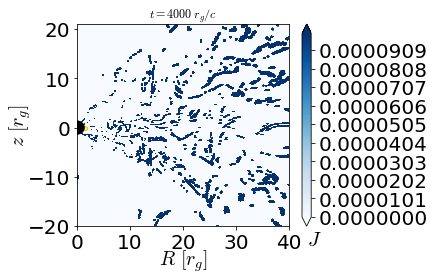

In [17]:
icoord = myi.tolist()
jcoord = myj.tolist()

#icenter, jcenter = 401,144
#icenter, jcenter = 75,437
#icenter, jcenter = 43,447
#icenter, jcenter = 27,255


rcenter = r[icenter][jcenter][0] * np.sin(h[icenter][jcenter][0])
hcenter = r[icenter][jcenter][0] * np.cos(h[icenter][jcenter][0])

icoord = [ int(element) for element in icoord]
jcoord = [ int(element) for element in jcoord]

rxx = []
ryy = []

for i in range(len(icoord)):
    rxx.append(r[icoord[i]][jcoord[i]][0] * np.sin(h[icoord[i]][jcoord[i]][0]))
    ryy.append(r[icoord[i]][jcoord[i]][0] * np.cos(h[icoord[i]][jcoord[i]][0]))


mirror = 1
if(mirror):
    xmax = 40
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 12
    xmax = 14
    ymin = -8
    ymax = -6
    step = 0.5

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()

#cs, cb = plco(Bphi, levels = np.linspace(-1, 1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
cs, cb = plco(JJ_cs_char, levels=np.linspace(0,10e-5,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')

#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

#plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)
plt.scatter(rxx, ryy, c ='orange', marker = 'o', s = 5)#, markersize = 0.01)
plt.scatter(rcenter, hcenter, c ='yellow', marker = 'o', s = 7)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$J$",fontsize=20,ha="left")
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

harm_script2.py:917: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax.set_ylim(-ymax,ymax)


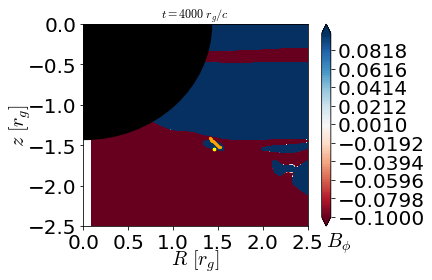

In [29]:
icoord = myi.tolist()
jcoord = myj.tolist()

#icenter, jcenter = 401,144
icenter, jcenter = 75,437
#icenter, jcenter = 43,447

#icenter, jcenter = 23,257
#icenter, jcenter = 396,74

rcenter = r[icenter][jcenter][0] * np.sin(h[icenter][jcenter][0])
hcenter = r[icenter][jcenter][0] * np.cos(h[icenter][jcenter][0])

icoord = [ int(element) for element in icoord]
jcoord = [ int(element) for element in jcoord]

rxx = []
ryy = []

for i in range(len(icoord)):
    rxx.append(r[icoord[i]][jcoord[i]][0] * np.sin(h[icoord[i]][jcoord[i]][0]))
    ryy.append(r[icoord[i]][jcoord[i]][0] * np.cos(h[icoord[i]][jcoord[i]][0]))


mirror = 0
if(mirror):
    xmax = 10
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 0
    xmax = 2.5
    ymin = -2.5
    ymax = 0
    step = 0.5

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()

cs, cb = plco(Bphi, levels = np.linspace(-0.1, 0.1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(JJ_cs_char, levels=np.linspace(0,10e-5,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')

#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

#plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)
plt.scatter(rxx, ryy, c ='orange', marker = 'o', s = 5)#, markersize = 0.01)
plt.scatter(rcenter, hcenter, c ='yellow', marker = 'o', s = 7)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
#cb.set_ticks([-1,-0.5,0,0.5,1.0])
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step), **hfont) #GS
    plt.xlim(xmin,xmax)
    plt.ylim(ymin,ymax)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

## GET GUIDE FIELDS

In [88]:
disc = 1
jet = 0

In [36]:
sigmaext = []
betaext = []
BrBphiext = []
BthBphiext = []
Vrecext = []
Vrecstdevext = []
                
dumpmin, dumpmax = 225, 800
#imin = 800
#imax = imin+400
for dumpnumber in range(dumpmin, dumpmax+1):
    
    Vrec_avg = 0.
    Vrec_count = 0
    Vrec = []
    
    for i in range(0,N1):
        for j in range(0,N2):
            for k in range(0,N3):
                if (disc):
                    myfilename = "/work/gustavo/gyst/sheets_disc/dump%03d_%d_%d_%d_s" %(dumpnumber,i,j,k)
                elif (jet):
                    myfilename = "/work/gustavo/gyst/sheets/dump%03d_%d_%d_%d_s" %(dumpnumber,i,j,k)
                if (os.path.isfile(myfilename)):
                    #print(i, j, k)

                    myfile = open(myfilename, "rb")
                    dtype = np.float64
                    body = np.fromfile(myfile,dtype=dtype,count=-1)
                    ind2 = int((len(body))/10)
                    mydata = body.view().reshape((10,ind2), order='F')
                    
                    myBr       = mydata[0]
                    myBth      = mydata[1]
                    myBphi     = mydata[2]
                    myJ        = mydata[3]
                    mybeta     = mydata[4]
                    mysigma    = mydata[5]
                    mysigmaphi = mydata[6]
                    myi        = mydata[7]
                    myj        = mydata[8]
                    myVrec     = mydata[9]
                    myfile.close()

                    sigmaext.append(mysigma[0])
                    sigmaext.append(mysigma[-1])
                    betaext.append(mybeta[0])
                    betaext.append(mybeta[-1])
                    BrBphiext.append(abs(B[1][i][j][k]/B[3][i][j][k]))
                    BthBphiext.append(abs(B[2][i][j][k]/B[3][i][j][k]))
                    Vrec.append(abs(myVrec[0]))
                    Vrec_count += 1
                    
    if (Vrec_count > 0):
        Vrec_avg = np.mean(Vrec)
        Vrec_stdev = np.std(Vrec)
        Vrecext.append(Vrec_avg)
        Vrecstdevext.append(Vrec_stdev)

In [37]:
BrBphiext = [x for x in BrBphiext if str(x) != 'nan']
BrBphiext = [x for x in BrBphiext if str(x) != 'inf']
BrBphiext = np.array(BrBphiext)

BthBphiext = [x for x in BthBphiext if str(x) != 'nan']
BthBphiext = [x for x in BthBphiext if str(x) != 'inf']
BthBphiext = np.array(BthBphiext)

betaext = [x for x in betaext if str(x) != 'nan']
betaext = [x for x in betaext if str(x) != 'inf']
betaext = np.array(betaext)

sigmaext = [x for x in sigmaext if str(x) != 'nan']
sigmaext = [x for x in sigmaext if str(x) != 'inf']
sigmaext = np.array(sigmaext)

Vrecext = [x for x in Vrecext if str(x) != 'nan']
Vrecext = [x for x in Vrecext if str(x) != 'inf']
Vrecext = np.array(Vrecext)

Vrecstdevext = [x for x in Vrecstdevext if str(x) != 'nan']
Vrecstdevext = [x for x in Vrecstdevext if str(x) != 'inf']
Vrecstdevext = np.array(Vrecstdevext)

In [38]:
# save quantities in files

if (jet):
    guidefield_r_file = open("guidefield_r_2D_jet.dat","w+")
elif (disc):
    guidefield_r_file = open("guidefield_r_2D_disc.dat","w+")
for line in range(len(BrBphiext)):
    guidefield_r_file.write(str(BrBphiext[line]))
    guidefield_r_file.write("\n")
guidefield_r_file.close()

if (jet):
    guidefield_th_file = open("guidefield_th_2D_jet.dat","w+")
elif (disc):
    guidefield_th_file = open("guidefield_th_2D_disc.dat","w+")
for line in range(len(BthBphiext)):
    guidefield_th_file.write(str(BthBphiext[line]))
    guidefield_th_file.write("\n")
guidefield_th_file.close()

if (jet):
    sigma_file = open("sigma_2D_jet.dat","w+")
elif (disc):
    sigma_file = open("sigma_2D_disc.dat","w+")
for line in range(len(sigmaext)):
    sigma_file.write(str(sigmaext[line]))
    sigma_file.write("\n")
sigma_file.close()

if (jet):
    beta_file = open("beta_2D_jet.dat","w+")
elif (disc):
    beta_file = open("beta_2D_disc.dat","w+")
for line in range(len(betaext)):
    beta_file.write(str(betaext[line]))
    beta_file.write("\n")
beta_file.close()

if (jet):
    Vrec_file = open("Vrec_2D_jet.dat", "w+")
elif (disc):
    Vrec_file = open("Vrec_2D_disc.dat", "w+")
for line in range(len(Vrecext)):
    Vrec_file.write(str(Vrecext[line]))
    Vrec_file.write(",")
    Vrec_file.write(str(Vrecstdevext[line]))
    Vrec_file.write("\n")
Vrec_file.close()

# Plot guide fields, plasma beta, magnetisation etc

In [11]:
disc = 0
jet = 1
savef = 0

### Plot guide fields (Br)

In [98]:
sum(value < 1 for value in BrBphiext)

harm_script2.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  import matplotlib


array([9126])

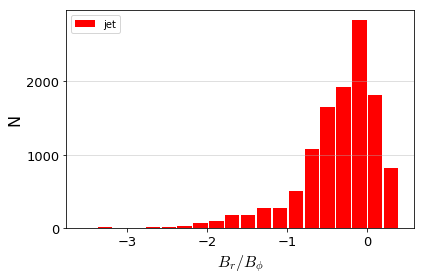

In [14]:
if (disc):
    myfilename = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
    myfigname = "BrBphi_2D_disc.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"
    myfigname = "BrBphi_2D_jet.png"
    mylabel = "jet"
    mycolor = "red"
    
myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
BrBphiext = mydata.values
BrBphiext_filt = BrBphiext[~is_outlier(BrBphiext)]
BrBphiext_filt = np.array(BrBphiext_filt)
myfile.close()

histmin = ((array(BrBphiext_filt)).min()).astype(float)
histmax = ((array(BrBphiext_filt)).max()).astype(float)

plt.hist(np.log10(BrBphiext_filt), bins=20, rwidth=0.9, range=[np.log10(histmin),np.log10(histmax)], label=mylabel, color = mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

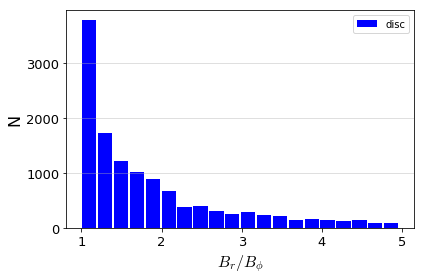

In [79]:
if (disc):
    myfilename = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
    myfigname = "BrBphi_2D_disc_large.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"
    myfigname = "BrBphi_2D_jet_large.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
BrBphiext = mydata.values
BrBphiext_filt = BrBphiext[~is_outlier(BrBphiext)]
BrBphiext_filt = np.array(BrBphiext_filt)
BrBphiext_large = BrBphiext[BrBphiext >= 1]
BrBphiext_large = BrBphiext_large[~is_outlier(BrBphiext_large)]
BrBphiext_large = np.array(BrBphiext_large)
myfile.close()

histmin = ((array(BrBphiext_large)).min()).astype(float)
histmax = ((array(BrBphiext_large)).max()).astype(float)

plt.hist(BrBphiext_large, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

### Plot guide fields (Bth)

In [ ]:
21 disc
3 jet

In [109]:
347/(347+12127)

0.027817861151194483

In [108]:
sum(value < 1 for value in BthBphiext)

harm_script2.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  import matplotlib


array([12127])

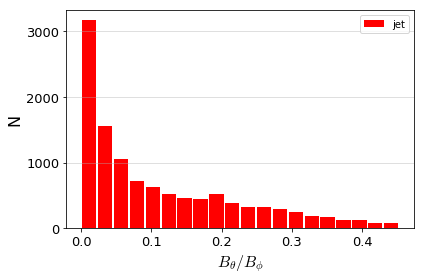

In [106]:
if (disc):
    myfilename = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
    myfigname = "BthBphi_2D_disc.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"
    myfigname = "BthBphi_2D_jet.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
BthBphiext = mydata.values
BthBphiext_filt = BthBphiext[~is_outlier(BthBphiext)]
BthBphiext_filt = np.array(BthBphiext_filt)
myfile.close()

histmin = ((array(BthBphiext_filt)).min()).astype(float)
histmax = ((array(BthBphiext_filt)).max()).astype(float)

plt.hist(BthBphiext_filt, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

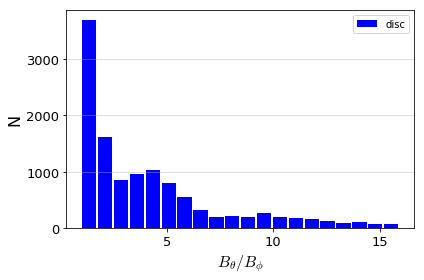

In [120]:
if (disc):
    myfilename = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
    myfigname = "BthBphi_2D_disc_large.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"
    myfigname = "BthBphi_2D_jet_large.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
BthBphiext = mydata.values
BthBphiext_filt = BthBphiext[~is_outlier(BthBphiext)]
BthBphiext_filt = np.array(BthBphiext_filt)
BthBphiext_large = BthBphiext[BthBphiext >= 1]
BthBphiext_large = BthBphiext_large[~is_outlier(BthBphiext_large)]
BthBphiext_large = np.array(BthBphiext_large)
myfile.close()

histmin = ((array(BthBphiext_large)).min()).astype(float)
histmax = ((array(BthBphiext_large)).max()).astype(float)

plt.hist(BthBphiext_large, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

### Plot magnetization

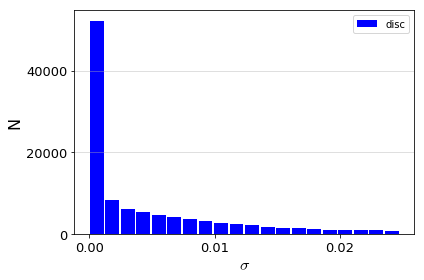

In [13]:
if (disc):
    myfilename = "/work/gustavo/gyst/sigma_2D_disc.dat"
    myfigname = "sigma_2D_disc.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/sigma_2D_jet.dat"
    myfigname = "sigma_2D_jet.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
sigmaext = mydata.values
sigmaext_filt = sigmaext[~is_outlier(sigmaext)]
sigmaext_filt = np.array(sigmaext_filt)
myfile.close()

histmin = ((array(sigmaext_filt)).min()).astype(float)
histmax = ((array(sigmaext_filt)).max()).astype(float)

plt.hist(sigmaext_filt, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

In [16]:
3804/(131766+3804)

0.028059305156007967

In [70]:
sum(value < 1 for value in betaext)

NameError: name 'betaext' is not defined

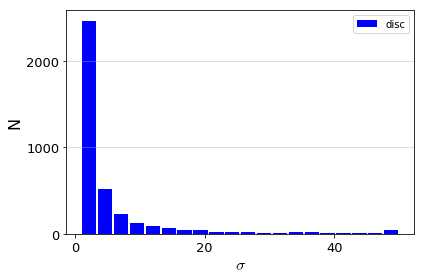

In [82]:
if (disc):
    myfilename = "/work/gustavo/gyst/sigma_2D_disc.dat"
    myfigname = "sigma_2D_disc_large.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/sigma_2D_jet.dat"
    myfigname = "sigma_2D_jet_large.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
sigmaext = mydata.values
sigmaext_filt = sigmaext[~is_outlier(sigmaext)]
sigmaext_filt = np.array(sigmaext_filt)
sigmaext_large = sigmaext[sigmaext >= 1]
#sigmaext_large = sigmaext_large[~is_outlier(sigmaext_large)]
sigmaext_large = np.array(sigmaext_large)
myfile.close()


histmin = ((array(sigmaext_large)).min()).astype(float)
histmax = ((array(sigmaext_large)).max()).astype(float)

plt.hist(sigmaext_large, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)


### Plot plasma beta

In [82]:
27527/(108043+27527)

0.2030463966954341

In [81]:
sum(value < 1 for value in betaext)

harm_script2.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.from_iter(generator)) or the python sum builtin instead.
  import matplotlib


array([27527])

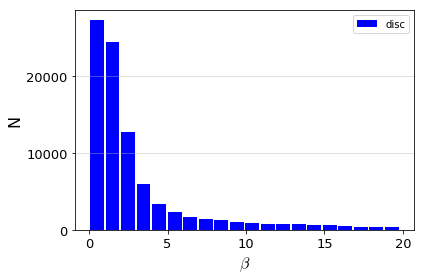

In [79]:
disc = 1
jet = 0
if (disc):
    myfilename = "/work/gustavo/gyst/beta_2D_disc.dat"
    myfigname = "beta_2D_disc.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/beta_2D_jet.dat"
    myfigname = "beta_2D_jet.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
betaext = mydata.values
betaext_filt = betaext[~is_outlier(betaext)]
betaext_filt = np.array(betaext_filt)
myfile.close()

histmin = ((array(betaext_filt)).min()).astype(float)
histmax = ((array(betaext_filt)).max()).astype(float)

plt.hist(betaext_filt, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
#if (savef):
#    plt.savefig(myfigname, dpi=150)

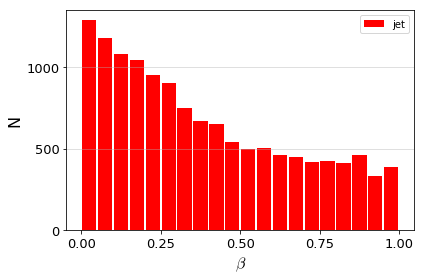

In [102]:
if (disc):
    myfilename = "/work/gustavo/gyst/beta_2D_disc.dat"
    myfigname = "beta_2D_disc_small.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/beta_2D_jet.dat"
    myfigname = "beta_2D_jet_small.png"
    mylabel = "jet"
    mycolor = "red"
    
myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
betaext = mydata.values
betaext_filt = betaext[~is_outlier(betaext)]
betaext_filt = np.array(betaext_filt)
betaext_small = betaext[betaext < 1]
betaext_small = betaext_small[~is_outlier(betaext_small)]
betaext_small = np.array(betaext_small)
myfile.close()

histmin = ((array(betaext_small)).min()).astype(float)
histmax = ((array(betaext_small)).max()).astype(float)

plt.hist(betaext_large, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

### Plot reconnection sites per snapshot

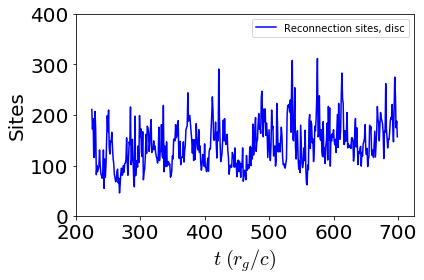

In [85]:
if (disc):
    myfilename = "/work/gustavo/gyst/sitecount_2D_disc.dat"
    mylabel = "Reconnection sites, disc"
    myfigname = "sitecount_disc.png"
    mycolor = "blue"
    ymin,ymax,ystep = 0,400,100
elif (jet):
    myfilename = "/work/gustavo/gyst/sitecount_2D_jet.dat"
    mylabel = "Reconnection sites, jet"
    myfigname = "sitecount_jet.png"
    mycolor = "red"
    ymin,ymax,ystep = 0,200,50

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, sep=',', header=None)
myfile.close()

dumpnumber = []
mydata = mydata.values
mydata = np.transpose(mydata)
sites = mydata[1]
for line in range(len(mydata[1])):
    dumpnumber.append(56+line)
    
dumpnumber = np.array(dumpnumber)
sites = np.array(sites)

plt.plot(dumpnumber[169:], sites[169:], alpha=1, label=mylabel, color=mycolor)
plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel("Sites")
xmin,xmax,xstep = 200,725,100
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xticks(np.arange(xmin, xmax+1, step=xstep))
plt.yticks(np.arange(ymin, ymax+1, step=ystep))
plt.legend(loc="best")
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

## MULTIPLOTS

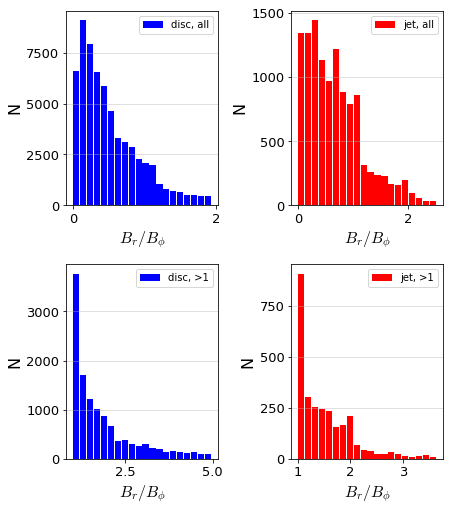

In [109]:
myfilename_d = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
BrBphiext_d = mydata_d.values
BrBphiext_filt_d = BrBphiext_d[~is_outlier(BrBphiext_d)]
BrBphiext_filt_d = np.array(BrBphiext_filt_d)
BrBphiext_large_d = BrBphiext_d[BrBphiext_d >= 1]
BrBphiext_large_d = BrBphiext_large_d[~is_outlier(BrBphiext_large_d)]
BrBphiext_large_d = np.array(BrBphiext_large_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
BrBphiext_j = mydata_j.values
BrBphiext_filt_j = BrBphiext_j[~is_outlier(BrBphiext_j)]
BrBphiext_filt_j = np.array(BrBphiext_filt_j)
BrBphiext_large_j = BrBphiext_j[BrBphiext_j >= 1]
BrBphiext_large_j = BrBphiext_large_j[~is_outlier(BrBphiext_large_j)]
BrBphiext_large_j = np.array(BrBphiext_large_j)
myfile_j.close()

histmin_d = ((array(BrBphiext_filt_d)).min()).astype(float)
histmax_d = ((array(BrBphiext_filt_d)).max()).astype(float)

histmin_j = ((array(BrBphiext_filt_j)).min()).astype(float)
histmax_j = ((array(BrBphiext_filt_j)).max()).astype(float)

histmin_large_d = ((array(BrBphiext_large_d)).min()).astype(float)
histmax_large_d = ((array(BrBphiext_large_d)).max()).astype(float)

histmin_large_j = ((array(BrBphiext_large_j)).min()).astype(float)
histmax_large_j = ((array(BrBphiext_large_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(BrBphiext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(BrBphiext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(BrBphiext_large_d, bins=20, rwidth=0.9, range=[histmin_large_d,histmax_large_d], label="disc, >1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(BrBphiext_large_j, bins=20, rwidth=0.9, range=[histmin_large_j,histmax_large_j], label="jet, >1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig("BrBphi_2D_multi", dpi=150)

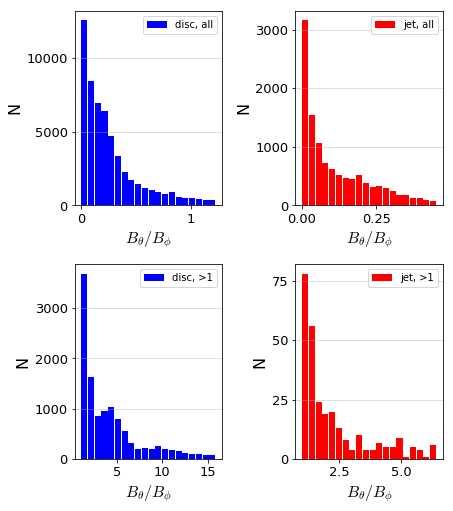

In [122]:
myfilename_d = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
BthBphiext_d = mydata_d.values
BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_d = np.array(BthBphiext_filt_d)
BthBphiext_large_d = BthBphiext_d[BthBphiext_d >= 1]
BthBphiext_large_d = BthBphiext_large_d[~is_outlier(BthBphiext_large_d)]
BthBphiext_large_d = np.array(BthBphiext_large_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
BthBphiext_j = mydata_j.values
BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_j = np.array(BthBphiext_filt_j)
BthBphiext_large_j = BthBphiext_j[BthBphiext_j >= 1]
BthBphiext_large_j = BthBphiext_large_j[~is_outlier(BthBphiext_large_j)]
BthBphiext_large_j = np.array(BthBphiext_large_j)
myfile_j.close()

histmin_d = ((array(BthBphiext_filt_d)).min()).astype(float)
histmax_d = ((array(BthBphiext_filt_d)).max()).astype(float)

histmin_j = ((array(BthBphiext_filt_j)).min()).astype(float)
histmax_j = ((array(BthBphiext_filt_j)).max()).astype(float)

histmin_large_d = ((array(BthBphiext_large_d)).min()).astype(float)
histmax_large_d = ((array(BthBphiext_large_d)).max()).astype(float)

histmin_large_j = ((array(BthBphiext_large_j)).min()).astype(float)
histmax_large_j = ((array(BthBphiext_large_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(BthBphiext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(BthBphiext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(BthBphiext_large_d, bins=20, rwidth=0.9, range=[histmin_large_d,histmax_large_d], label="disc, >1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(BthBphiext_large_j, bins=20, rwidth=0.9, range=[histmin_large_j,histmax_large_j], label="jet, >1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig("BthBphi_2D_multi", dpi=150)

In [ ]:
myfilename_d = "/work/gustavo/gyst/sigma_2D_disc.dat"
#myfigname_d = "sigma_2D_disc_multi.png"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/sigma_2D_jet.dat"
#myfigname_j = "sigma_2D_jet_multi.png"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
sigmaext_d = mydata_d.values
sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
sigmaext_j = mydata_j.values
sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_j.close()

histmin_d = ((array(sigmaext_filt_d)).min()).astype(float)
histmax_d = ((array(sigmaext_filt_d)).max()).astype(float)

histmin_j = ((array(sigmaext_filt_j)).min()).astype(float)
histmax_j = ((array(sigmaext_filt_j)).max()).astype(float)

histmin_large_d = ((array(sigmaext_large_d)).min()).astype(float)
histmax_large_d = ((array(sigmaext_large_d)).max()).astype(float)

histmin_large_j = ((array(sigmaext_large_j)).min()).astype(float)
histmax_large_j = ((array(sigmaext_large_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(sigmaext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(sigmaext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(sigmaext_large_d, bins=20, rwidth=0.9, range=[histmin_large_d,histmax_large_d], label="disc, >1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(sigmaext_large_j, bins=20, rwidth=0.9, range=[histmin_large_j,histmax_large_j], label="jet, >1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig("sigma_2D_multi", dpi=150)

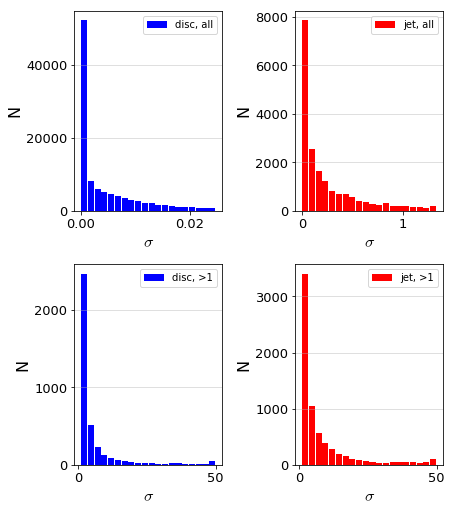

In [103]:
myfilename_d = "/work/gustavo/gyst/sigma_2D_disc.dat"
#myfigname_d = "sigma_2D_disc_multi.png"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/sigma_2D_jet.dat"
#myfigname_j = "sigma_2D_jet_multi.png"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
sigmaext_d = mydata_d.values
sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
sigmaext_j = mydata_j.values
sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_j.close()

histmin_d = ((array(sigmaext_filt_d)).min()).astype(float)
histmax_d = ((array(sigmaext_filt_d)).max()).astype(float)

histmin_j = ((array(sigmaext_filt_j)).min()).astype(float)
histmax_j = ((array(sigmaext_filt_j)).max()).astype(float)

histmin_large_d = ((array(sigmaext_large_d)).min()).astype(float)
histmax_large_d = ((array(sigmaext_large_d)).max()).astype(float)

histmin_large_j = ((array(sigmaext_large_j)).min()).astype(float)
histmax_large_j = ((array(sigmaext_large_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(sigmaext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(sigmaext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(sigmaext_large_d, bins=20, rwidth=0.9, range=[histmin_large_d,histmax_large_d], label="disc, >1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(sigmaext_large_j, bins=20, rwidth=0.9, range=[histmin_large_j,histmax_large_j], label="jet, >1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig("sigma_2D_multi", dpi=150)

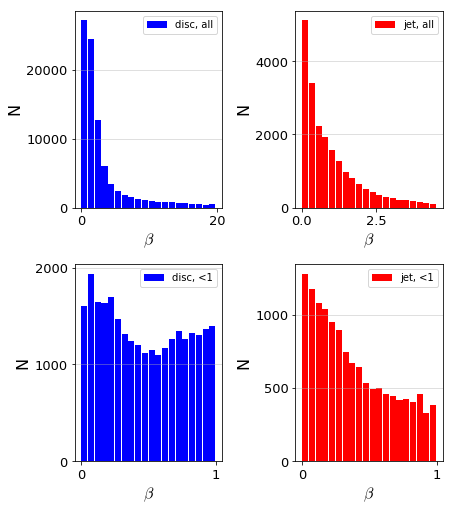

In [104]:
myfilename_d = "/work/gustavo/gyst/beta_2D_disc.dat"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/beta_2D_jet.dat"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
betaext_d = mydata_d.values
betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
betaext_filt_d = np.array(betaext_filt_d)
betaext_small_d = betaext_d[betaext_d < 1]
betaext_small_d = np.array(betaext_small_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
betaext_j = mydata_j.values
betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
betaext_filt_j = np.array(betaext_filt_j)
betaext_small_j = betaext_j[betaext_j < 1]
betaext_small_j = np.array(betaext_small_j)
myfile_j.close()

histmin_d = ((array(betaext_filt_d)).min()).astype(float)
histmax_d = ((array(betaext_filt_d)).max()).astype(float)

histmin_j = ((array(betaext_filt_j)).min()).astype(float)
histmax_j = ((array(betaext_filt_j)).max()).astype(float)

histmin_small_d = ((array(betaext_small_d)).min()).astype(float)
histmax_small_d = ((array(betaext_small_d)).max()).astype(float)

histmin_small_j = ((array(betaext_small_j)).min()).astype(float)
histmax_small_j = ((array(betaext_small_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(betaext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(betaext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(betaext_small_d, bins=20, rwidth=0.9, range=[histmin_small_d,histmax_small_d], label="disc, <1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(betaext_small_j, bins=20, rwidth=0.9, range=[histmin_small_j,histmax_small_j], label="jet, <1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig("beta_2D_multi", dpi=150)

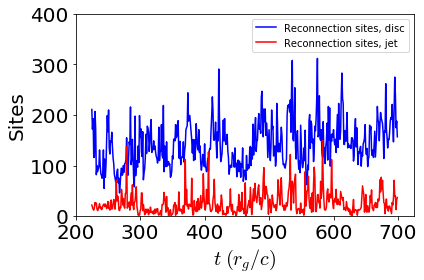

In [126]:
myfilename_d = "/work/gustavo/gyst/sitecount_2D_disc.dat"
mylabel_d = "Reconnection sites, disc"
mycolor_d = "blue"
    
myfilename_j = "/work/gustavo/gyst/sitecount_2D_jet.dat"
mylabel_j = "Reconnection sites, jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, sep=',', header=None)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, sep=',', header=None)
myfile_j.close()

dumpnumber_d = []
mydata_d = mydata_d.values
mydata_d = np.transpose(mydata_d)
sites_d = mydata_d[1]
for line in range(len(mydata_d[1])):
    dumpnumber_d.append(56+line)

dumpnumber_j = []
mydata_j = mydata_j.values
mydata_j = np.transpose(mydata_j)
sites_j = mydata_j[1]
for line in range(len(mydata_j[1])):
    dumpnumber_j.append(56+line)
    
dumpnumber_d = np.array(dumpnumber_d)
sites_d = np.array(sites_d)

dumpnumber_j = np.array(dumpnumber_j)
sites_j = np.array(sites_j)

plt.plot(dumpnumber_d[169:], sites_d[169:], alpha=1, label=mylabel_d, color=mycolor_d)
plt.plot(dumpnumber_j[169:], sites_j[169:], alpha=1, label=mylabel_j, color=mycolor_j)

plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel("Sites")
xmin,xmax,xstep = 200,725,100
ymin,ymax,ystep = 0,400,100
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xticks(np.arange(xmin, xmax+1, step=xstep))
plt.yticks(np.arange(ymin, ymax+1, step=ystep))
plt.legend(loc="best")
plt.tight_layout()
if (savef):
    plt.savefig("sitecount.png", dpi=150)

<Figure size 460.8x518.4 with 0 Axes>

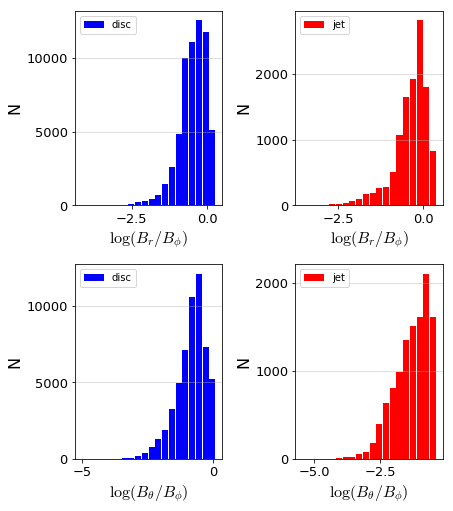

In [17]:
mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

myfilename_rd = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
myfilename_rj = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"

myfile_rd = open(myfilename_rd, "r")
mydata_rd = pd.read_csv(myfilename_rd, header=None)
BrBphiext_d = mydata_rd.values
#BrBphiext_filt_d = BrBphiext_d[~is_outlier(BrBphiext_d)]
BrBphiext_filt_d = np.array(BrBphiext_filt_d)
BrBphiext_large_d = BrBphiext_d[BrBphiext_d >= 1]
BrBphiext_large_d = BrBphiext_large_d[~is_outlier(BrBphiext_large_d)]
BrBphiext_large_d = np.array(BrBphiext_large_d)
myfile_rd.close()

myfile_rj = open(myfilename_rj, "r")
mydata_rj = pd.read_csv(myfilename_rj, header=None)
BrBphiext_r = mydata_rj.values
#BrBphiext_filt_r = BrBphiext_j[~is_outlier(BrBphiext_j)]
BrBphiext_filt_r = np.array(BrBphiext_filt_j)
BrBphiext_large_r = BrBphiext_j[BrBphiext_j >= 1]
BrBphiext_large_r = BrBphiext_large_j[~is_outlier(BrBphiext_large_j)]
BrBphiext_large_r = np.array(BrBphiext_large_j)
myfile_rj.close()

histmin_rd = np.log10(((array(BrBphiext_filt_d)).min()).astype(float))
histmax_rd = np.log10(((array(BrBphiext_filt_d)).max()).astype(float))

histmin_rj = np.log10(((array(BrBphiext_filt_j)).min()).astype(float))
histmax_rj = np.log10(((array(BrBphiext_filt_j)).max()).astype(float))

histmin_large_rd = np.log10(((array(BrBphiext_large_d)).min()).astype(float))
histmax_large_rd = np.log10(((array(BrBphiext_large_d)).max()).astype(float))

histmin_large_rj = np.log10(((array(BrBphiext_large_j)).min()).astype(float))
histmax_large_rj = np.log10(((array(BrBphiext_large_j)).max()).astype(float))


################################



myfilename_thd = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
myfilename_thj = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"

myfile_thd = open(myfilename_thd, "r")
mydata_thd = pd.read_csv(myfilename_thd, header=None)
BthBphiext_d = mydata_thd.values
#BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_d = np.array(BthBphiext_filt_d)
BthBphiext_large_d = BthBphiext_d[BthBphiext_d >= 1]
BthBphiext_large_d = BthBphiext_large_d[~is_outlier(BthBphiext_large_d)]
BthBphiext_large_d = np.array(BthBphiext_large_d)
myfile_thd.close()

myfile_thj = open(myfilename_thj, "r")
mydata_thj = pd.read_csv(myfilename_thj, header=None)
BthBphiext_j = mydata_thj.values
#BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_j = np.array(BthBphiext_filt_j)
BthBphiext_large_j = BthBphiext_j[BthBphiext_j >= 1]
BthBphiext_large_j = BthBphiext_large_j[~is_outlier(BthBphiext_large_j)]
BthBphiext_large_j = np.array(BthBphiext_large_j)
myfile_thj.close()

histmin_thd = np.log10(((array(BthBphiext_filt_d)).min()).astype(float))
histmax_thd = np.log10(((array(BthBphiext_filt_d)).max()).astype(float))

histmin_thj = np.log10(((array(BthBphiext_filt_j)).min()).astype(float))
histmax_thj = np.log10(((array(BthBphiext_filt_j)).max()).astype(float))

histmin_large_thd = np.log10(((array(BthBphiext_large_d)).min()).astype(float))
histmax_large_thd = np.log10(((array(BthBphiext_large_d)).max()).astype(float))

histmin_large_thj = np.log10(((array(BthBphiext_large_j)).min()).astype(float))
histmax_large_thj = np.log10(((array(BthBphiext_large_j)).max()).astype(float))

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(BrBphiext_filt_d), bins=20, rwidth=0.9, range=[histmin_rd,histmax_rd], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(BrBphiext_filt_j), bins=20, rwidth=0.9, range=[histmin_rj,histmax_rj], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[histmin_thd,histmax_thd], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[histmin_thj,histmax_thj], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig("log_guidefield_2D_multi", dpi=150)

<Figure size 460.8x518.4 with 0 Axes>

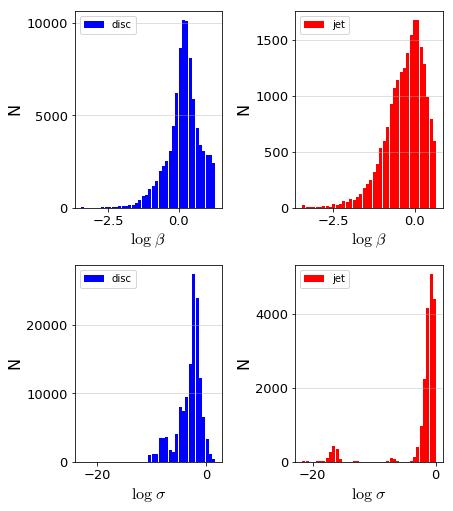

In [29]:
mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

myfilename_bd = "/work/gustavo/gyst/beta_2D_disc.dat"
myfilename_bj = "/work/gustavo/gyst/beta_2D_jet.dat"

myfile_bd = open(myfilename_bd, "r")
mydata_bd = pd.read_csv(myfilename_bd, header=None)
betaext_d = mydata_bd.values
betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
#betaext_filt_d = betaext_d
betaext_filt_d = np.array(betaext_filt_d)
betaext_small_d = betaext_d[betaext_d < 1]
betaext_small_d = np.array(betaext_small_d)
myfile_bd.close()

myfile_bj = open(myfilename_bj, "r")
mydata_bj = pd.read_csv(myfilename_bj, header=None)
betaext_j = mydata_bj.values
betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
#betaext_filt_j = betaext_j
betaext_filt_j = np.array(betaext_filt_j)
betaext_small_j = betaext_j[betaext_j < 1]
betaext_small_j = np.array(betaext_small_j)
myfile_bj.close()

histmin_bd = np.log10(((array(betaext_filt_d)).min()).astype(float))
histmax_bd = np.log10(((array(betaext_filt_d)).max()).astype(float))

histmin_bj = np.log10(((array(betaext_filt_j)).min()).astype(float))
histmax_bj = np.log10(((array(betaext_filt_j)).max()).astype(float))

histmin_small_bd = np.log10(((array(betaext_small_d)).min()).astype(float))
histmax_small_bd = np.log10(((array(betaext_small_d)).max()).astype(float))

histmin_small_bj = np.log10(((array(betaext_small_j)).min()).astype(float))
histmax_small_bj = np.log10(((array(betaext_small_j)).max()).astype(float))


################################

myfilename_sd = "/work/gustavo/gyst/sigma_2D_disc.dat"
myfilename_sj = "/work/gustavo/gyst/sigma_2D_jet.dat"

myfile_sd = open(myfilename_sd, "r")
mydata_sd = pd.read_csv(myfilename_sd, header=None)
sigmaext_d = mydata_sd.values
#sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = sigmaext_d
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_sd.close()

myfile_sj = open(myfilename_sj, "r")
mydata_sj = pd.read_csv(myfilename_sj, header=None)
sigmaext_j = mydata_sj.values
sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
#sigmaext_filt_j = sigmaext_j
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_sj.close()

histmin_sd = np.log10(((array(sigmaext_filt_d)).min()).astype(float))
histmax_sd = np.log10(((array(sigmaext_filt_d)).max()).astype(float))

histmin_sj = np.log10(((array(sigmaext_filt_j)).min()).astype(float))
histmax_sj = np.log10(((array(sigmaext_filt_j)).max()).astype(float))

histmin_large_sd = np.log10(((array(sigmaext_large_d)).min()).astype(float))
histmax_large_sd = np.log10(((array(sigmaext_large_d)).max()).astype(float))

histmin_large_sj = np.log10(((array(sigmaext_large_j)).min()).astype(float))
histmax_large_sj = np.log10(((array(sigmaext_large_j)).max()).astype(float))


##################################


hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(betaext_filt_d), bins=40, rwidth=0.9, range=[histmin_bd,histmax_bd], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(betaext_filt_j), bins=40, rwidth=0.9, range=[histmin_bj,histmax_bj], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(sigmaext_filt_d), bins=40, rwidth=0.9, range=[histmin_sd,histmax_sd], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(sigmaext_filt_j), bins=40, rwidth=0.9, range=[histmin_sj,histmax_sj], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("log_betasigma_2D_multi", dpi=150)

In [37]:
mean_BrBphi_d = np.mean(BrBphiext_filt_d)
std_BrBphi_d = np.std(BrBphiext_filt_d)
median_BrBphi_d = np.median(BrBphiext_filt_d)

mean_BrBphi_j = np.mean(BrBphiext_filt_j)
std_BrBphi_j = np.std(BrBphiext_filt_j)
median_BrBphi_j = np.median(BrBphiext_filt_j)

mean_BthBphi_d = np.mean(BthBphiext_filt_d)
std_BthBphi_d = np.std(BthBphiext_filt_d)
median_BthBphi_d = np.median(BthBphiext_filt_d)

mean_BthBphi_j = np.mean(BthBphiext_filt_j)
std_BthBphi_j = np.std(BthBphiext_filt_j)
median_BthBphi_j = np.median(BthBphiext_filt_j)

mean_beta_d = np.mean(betaext_filt_d)
std_beta_d = np.std(betaext_filt_d)
median_beta_d = np.median(betaext_filt_d)

mean_beta_j = np.mean(betaext_filt_j)
std_beta_j = np.std(betaext_filt_j)
median_beta_j = np.median(betaext_filt_j)

mean_sigma_d = np.mean(sigmaext_filt_d)
std_sigma_d = np.std(sigmaext_filt_d)
median_sigma_d = np.median(sigmaext_filt_d)

mean_sigma_j = np.mean(sigmaext_filt_j)
std_sigma_j = np.std(sigmaext_filt_j)
median_sigma_j = np.median(sigmaext_filt_j)

In [38]:
mean_BrBphi_d,std_BrBphi_d,median_BrBphi_d

(0.5099462970246298, 0.4140984007105534, 0.39366966)

In [39]:
mean_BrBphi_j,std_BrBphi_j,median_BrBphi_j

(0.6693559785231191, 0.5082937268738245, 0.5703214)

In [40]:
mean_BthBphi_d,std_BthBphi_d,median_BthBphi_d

(0.26148651602954265, 0.2613780643757825, 0.18139876)

In [41]:
mean_BthBphi_j,std_BthBphi_j,median_BthBphi_j

(0.11017818414880347, 0.11100938225261144, 0.06594333050000001)

In [42]:
mean_beta_d,std_beta_d,median_beta_d

(3.0104423878581055, 3.808726446412348, 1.6317487442597758)

In [43]:
mean_beta_j,std_beta_j,median_beta_j

(0.9629003799535198, 0.9651484312766668, 0.6389447597250323)

In [44]:
mean_sigma_d,std_sigma_d,median_sigma_d

(0.19370748626618095, 1.7543031579720483, 0.003997249308470816)

In [45]:
mean_sigma_j,std_sigma_j,median_sigma_j

(2.226108542434867, 6.308375249749326, 0.21988184935999702)

In [17]:
disc = 0
jet = 1
savef = 0

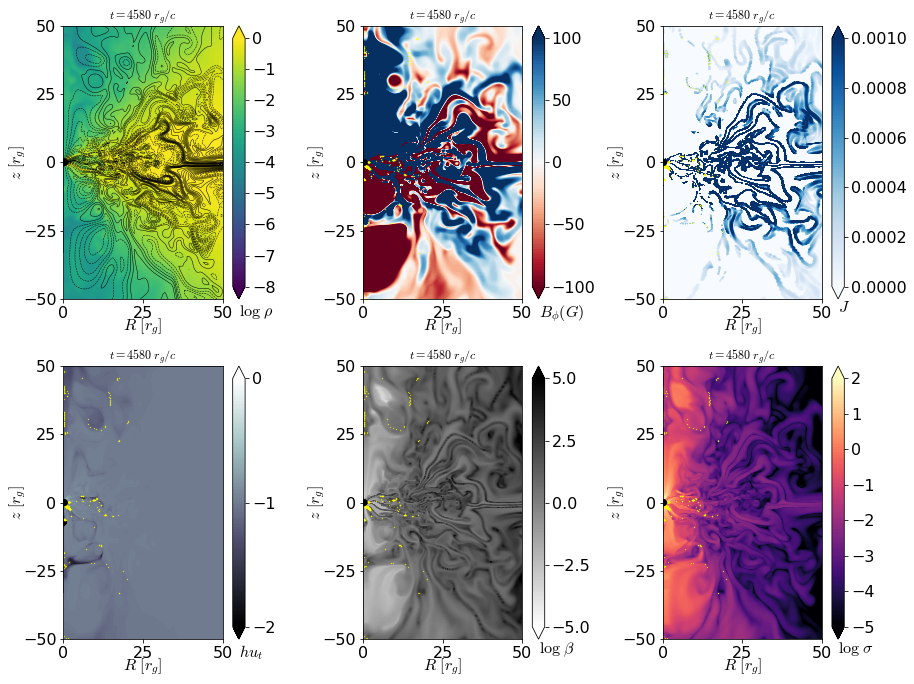

In [62]:
if (disc):
    myfigname = "quantities_2D_disc_"+str(int(np.round(t)))+".png"
elif (jet):
    myfigname = "quantities_2D_jet_"+str(int(np.round(t)))+".png"

savef = 0
fontsize = 16

mirror = 1
if(mirror):
    xmin = 0
    xmax = 50
    ymin = -xmax
    ymax = xmax
    step = xmax/2
else:
    xmin = 0
    xmax = 150
    ymin = -250
    ymax = -100
    step = 50

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[12.8, 9.6])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,3)


ax1 = plt.subplot(gs[0,0])
aphi=psicalc()
amax = aphi.max()
cs1,cb1 = plc(np.log10(rho),
              levels=np.linspace(-8, 0, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1,
              fntsize=fontsize)
ax1 = plt.gca()
ax1.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5, **hfont)
ax1.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5, **hfont)
cb1.ax.set_xlabel(r"$\log\;\rho$",fontsize=fontsize,ha="left")
cb1.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
ax1.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()


ax2 = plt.subplot(gs[0,1])
cs2,cb2 = plc(Bphi*B_unit, 
              levels=np.linspace(-100, 100, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax2 = plt.gca()
ax2.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5)
ax2.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5)
cb2.ax.set_xlabel(r"$B_\phi(G)$",fontsize=fontsize,ha="left")
cb2.set_ticks([-100,-50,0,50,100])
ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
#ax1.set_xticklabels(np.arange(int(xmin), int(xmax+1), step=step), fontsize=12)
ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
#ax1.set_yticklabels(np.arange(int(ymin), int(ymax+1), step=step), fontsize=12)
ax2.tick_params(axis="x", labelsize=fontsize)
ax2.tick_params(axis="y", labelsize=fontsize)
ax2.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()


ax3 = plt.subplot(gs[0,2])
cs3,cb3 = plc(JJ_cs, 
              levels=np.linspace(0,10e-4,100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='Blues',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax3 = plt.gca()
ax3.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5)
ax3.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5)
cb3.ax.set_xlabel(r"$J$",fontsize=16, labelpad=1, ha="left")
cb3.set_ticks([0,0.0002,0.0004,0.0006,0.0008,0.001])
ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
#ax2.set_xticklabels(np.arange(int(xmin), int(xmax+1), step=step), fontsize=12)
ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
#ax2.set_yticklabels(np.arange(int(ymin), int(ymax+1), step=step), fontsize=12)
ax3.tick_params(axis="x", labelsize=fontsize)
ax3.tick_params(axis="y", labelsize=fontsize)
ax3.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()


ax4 = plt.subplot(gs[1,0])
cs4,cb4 = plc(unb,
              levels = np.linspace(-2,0, 100),
              isfilled=1,
              k=0,
              xy=1,
              xmax=xmax,
              ymax=ymax,
              dobh=1,
              cb=1,
              extend="both",
              pretty=1,
              cmap = 'bone',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax4 = plt.gca()
ax4.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5, **hfont)
ax4.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5, **hfont)
cb4.ax.set_xlabel(r"$hu_t$",fontsize=fontsize,ha="left")
cb4.set_ticks([-2,-1,0])
if(mirror):
    ax4.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax4.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax4.tick_params(axis="x", labelsize=fontsize)
    ax4.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
ax4.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()



ax5 = plt.subplot(gs[1,1])
cs5,cb5 = plc(np.log10(betapl), 
              levels=np.linspace(-5, 5, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='binary',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax5 = plt.gca()
ax5.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5)
ax5.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5)
cb5.ax.set_xlabel(r"$\log\;\beta$",fontsize=fontsize, labelpad=1, ha="left")
cb5.set_ticks([-5,-2.5,0,2.5,5])
ax5.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
#ax2.set_xticklabels(np.arange(int(xmin), int(xmax+1), step=step), fontsize=12)
ax5.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
#ax2.set_yticklabels(np.arange(int(ymin), int(ymax+1), step=step), fontsize=12)
ax5.tick_params(axis="x", labelsize=fontsize)
ax5.tick_params(axis="y", labelsize=fontsize)
ax5.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()


ax6 = plt.subplot(gs[1,2])
cs6,cb6 = plc(np.log10(sigma), 
              levels=np.linspace(-5, 2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax6 = plt.gca()
ax6.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5)
ax6.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5)
cb6.ax.set_xlabel(r"$\log\;\sigma$",fontsize=fontsize, labelpad=1, ha="left")
cb6.set_ticks([-5,-4,-3,-2,-1,0,1,2])
ax6.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
#ax6.set_xticklabels(np.arange(int(xmin), int(xmax+1), step=step), fontsize=12)
ax6.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
#ax6.set_yticklabels(np.arange(int(ymin), int(ymax+1), step=step), fontsize=12)
ax6.tick_params(axis="x", labelsize=fontsize)
ax6.tick_params(axis="y", labelsize=fontsize)
ax6.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()

plt.show()
if (savef):
    plt.savefig(myfigname, dpi = 150)

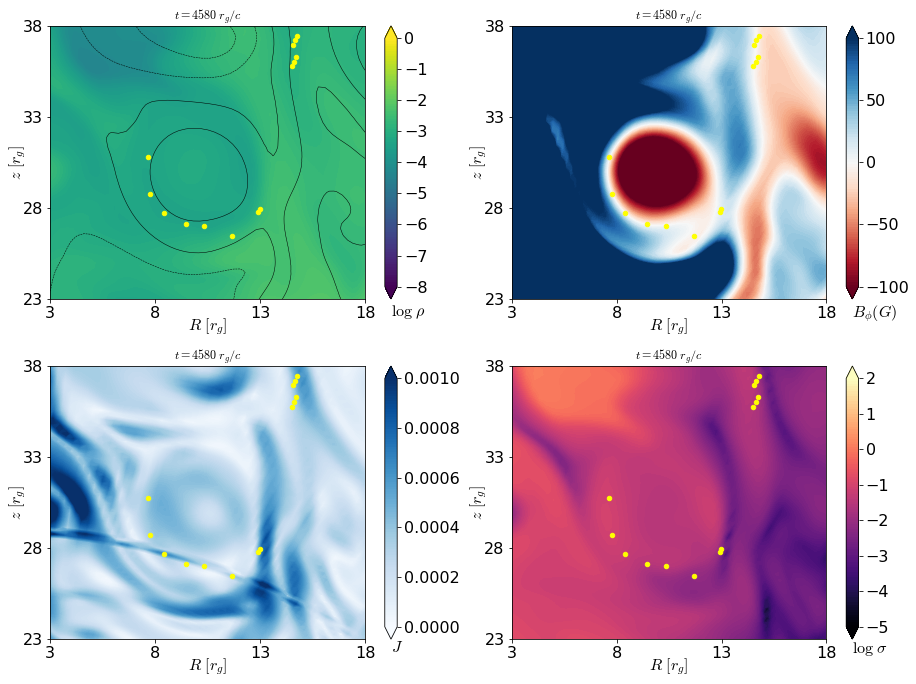

In [69]:

    
if (disc):
    myfigname = "zoom_2D_disc_"+str(int(np.round(t)))+".png"
elif (jet):
    myfigname = "zoom_2D_jet_"+str(int(np.round(t)))+".png"

savef = 0
fontsize = 16

mirror = 0
if(mirror):
    xmax = 50
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 3
    xmax = 18
    ymin = 23
    ymax = 38
    step = 5

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[12.8, 9.6])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
aphi=psicalc()
amax = aphi.max()
cs1,cb1 = plc(np.log10(rho),
              levels=np.linspace(-8, 0, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1,
              fntsize=fontsize)
ax1 = plt.gca()
ax1.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5, **hfont)
ax1.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5, **hfont)
cb1.ax.set_xlabel(r"$\log\;\rho$",fontsize=fontsize,ha="left")
cb1.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
else:
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 20)#, markersize = 0.01)
plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
ax1.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()


ax2 = plt.subplot(gs[0,1])
cs2,cb2 = plc(Bphi*B_unit, 
              levels=np.linspace(-100, 100, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 20)#, markersize = 0.01)
ax2 = plt.gca()
ax2.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5)
ax2.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5)
cb2.ax.set_xlabel(r"$B_\phi(G)$",fontsize=fontsize,ha="left")
cb2.set_ticks([-100,-50,0,50,100])
if(mirror):
    ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax2.set_xlim(xmin,xmax)
    ax2.set_ylim(ymin,ymax)
else:
    ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax2.set_xlim(xmin,xmax)
    ax2.set_ylim(ymin,ymax)
ax2.tick_params(axis="x", labelsize=fontsize)
ax2.tick_params(axis="y", labelsize=fontsize)
ax2.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()


ax3 = plt.subplot(gs[1,0])
cs3,cb3 = plc(JJJ,#JJ_cs, 
              levels=np.linspace(0,10e-4,100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='Blues',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 20)#, markersize = 0.01)
ax3 = plt.gca()
ax3.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5)
ax3.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5)
cb3.ax.set_xlabel(r"$J$",fontsize=16, labelpad=1, ha="left")
cb3.set_ticks([0,0.0002,0.0004,0.0006,0.0008,0.001])
if(mirror):
    ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax3.set_xlim(xmin,xmax)
    ax3.set_ylim(ymin,ymax)
else:
    ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax3.set_xlim(xmin,xmax)
    ax3.set_ylim(ymin,ymax)
ax3.tick_params(axis="x", labelsize=fontsize)
ax3.tick_params(axis="y", labelsize=fontsize)
ax3.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
cs4,cb4 = plc(np.log10(sigma), 
              levels=np.linspace(-5, 2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 20)#, markersize = 0.01)
ax4 = plt.gca()
ax4.set_xlabel(r"$R\ [r_g]$",fontsize=fontsize,labelpad=-5)
ax4.set_ylabel(r"$z\ [r_g]$",fontsize=fontsize,labelpad=-5)
cb4.ax.set_xlabel(r"$\log\;\sigma$",fontsize=fontsize, labelpad=1, ha="left")
cb4.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax4.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax4.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax4.set_xlim(xmin,xmax)
    ax4.set_ylim(ymin,ymax)
else:
    ax4.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax4.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax4.set_xlim(xmin,xmax)
    ax4.set_ylim(ymin,ymax)
ax4.tick_params(axis="x", labelsize=fontsize)
ax4.tick_params(axis="y", labelsize=fontsize)
ax4.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()

plt.show()
if (savef):
    plt.savefig(myfigname, dpi = 150)

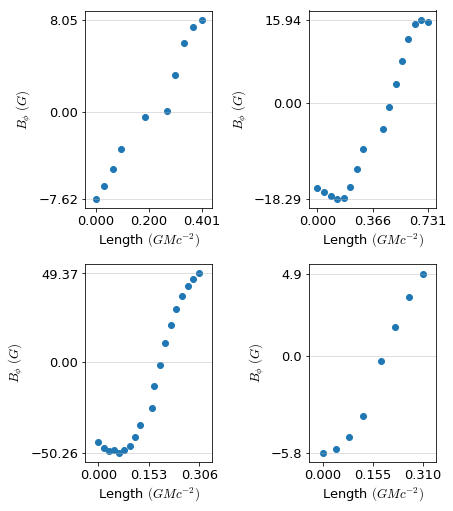

In [67]:
myfilename = ["/work/gustavo/gyst/sheets/dump506_187_443_0_s",
              "/work/gustavo/gyst/sheets/dump520_175_27_0_s",
              "/work/gustavo/gyst/sheets/dump532_90_186_0_s",
              "/work/gustavo/gyst/sheets/dump540_210_95_0_s",
              "/work/gustavo/gyst/sheets/dump547_79_433_0_s"]

icenter=[187,175,90,210,79]
jcenter=[443,27,186,95,433]

posno = []
xminl = []
xmidl = []
xmaxl = []
yminl = []
ymaxl = []
Bphisheet = []

for sheetno in range(len(myfilename)):
    
    myfile = open(myfilename[sheetno], "rb")
    dtype = np.float64
    body = np.fromfile(myfile,dtype=dtype,count=-1)
    ind2 = int((len(body))/10)
    mydata = body.view().reshape((10,ind2), order='F')

    myBr       = mydata[0]
    myBth      = mydata[1]
    myBphi     = mydata[2]
    myJ        = mydata[3]
    mybeta     = mydata[4]
    mysigma    = mydata[5]
    mysigmaphi = mydata[6]
    myi        = mydata[7]
    myj        = mydata[8]

    myfile.close()

    position = []
    for ii in range(len(myBr)):
        if ii == 0:
            distance = 0
            distanceold = 0
        else:
            r1 = r[int(myi[ii])][int(myj[ii])][0]
            r2 = r[int(myi[ii-1])][int(myj[ii-1])][0]
            th1 = h[int(myi[ii])][int(myj[ii])][0]
            th2 = h[int(myi[ii-1])][int(myj[ii-1])][0]
            distance = np.sqrt(r1*r1 + r2*r2 - 2*r1*r2*np.cos(th1 - th2)) + distanceold
            distanceold = distance
        position.append(distance)
    position = np.array(position)

    xmin = round(min(position), 3)
    xmax = round(max(position), 3)
    xmid = round((xmax-xmin)/2, 3)
    xmmin = round((xmid-xmin)/2, 3)
    xmmax = round(xmax-xmid/2, 3)
    ymin1 = round(min(myBphi)*B_unit, 3)
    ymax1 = round(max(myBphi)*B_unit, 3)
    ymid1 = round(0.5*(ymax1+ymin1), 3)

    xminl.append(xmin)
    xmidl.append(xmid)
    xmaxl.append(xmax)
    yminl.append(ymin1)
    ymaxl.append(ymax1)
    Bphisheet.append(myBphi)
    
    #yticks[sheetno] = [ymin1,0,ymax1]
    posno.append(position)


color = 'tab:blue'
hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)

Bphisheet[0] = np.flip(Bphisheet[0])
Bphisheet[1] = np.flip(Bphisheet[1])
Bphisheet[2] = np.flip(Bphisheet[2])

Bphisheet[1] = np.delete(Bphisheet[1], 8)
Bphisheet[1] = np.delete(Bphisheet[1], 8)
posno[1] = np.delete(posno[1], 8)
posno[1] = np.delete(posno[1], 8)

Bphisheet[2] = np.delete(Bphisheet[2], 9)
posno[2] = np.delete(posno[2], 9)

ax1 = plt.subplot(gs[0,0])
ax1.scatter(posno[0], Bphisheet[0]*B_unit, color=color)
_, max_ = plt.ylim()
plt.xlabel(r'Length $(GMc^{-2})$', fontsize=13)
plt.ylabel(r'$B_\phi\;(G)$', fontsize=13)
plt.grid(axis='y', alpha=0.5)
xticks = [xminl[0],xmidl[0],xmaxl[0]]
yticks = [yminl[0],0,ymaxl[0]]
plt.xticks(xticks, fontsize=13)
plt.yticks(yticks, fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
ax2.scatter(posno[1], Bphisheet[1]*B_unit, color=color)
_, max_ = plt.ylim()
plt.xlabel(r'Length $(GMc^{-2})$', fontsize=13)
plt.ylabel(r'$B_\phi\;(G)$', fontsize=13)
plt.grid(axis='y', alpha=0.5)
xticks = [xminl[1],xmidl[1],xmaxl[1]]
yticks = [yminl[1],0,ymaxl[1]]
plt.xticks(xticks, fontsize=13)
plt.yticks(yticks, fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
ax3.scatter(posno[2], Bphisheet[2]*B_unit, color=color)
_, max_ = plt.ylim()
plt.xlabel(r'Length $(GMc^{-2})$', fontsize=13)
plt.ylabel(r'$B_\phi\;(G)$', fontsize=13)
plt.grid(axis='y', alpha=0.5)
xticks = [xminl[2],xmidl[2],xmaxl[2]]
yticks = [yminl[2],0,ymaxl[2]]
plt.xticks(xticks, fontsize=13)
plt.yticks(yticks, fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
ax4.scatter(posno[3], Bphisheet[3]*B_unit, color=color)
_, max_ = plt.ylim()
plt.xlabel(r'Length $(GMc^{-2})$', fontsize=13)
plt.ylabel(r'$B_\phi\;(G)$', fontsize=13)
plt.grid(axis='y', alpha=0.5)
xticks = [xminl[3],xmidl[3],xmaxl[3]]
yticks = [yminl[3],0,ymaxl[3]]
plt.xticks(xticks, fontsize=13)
plt.yticks(yticks, fontsize=13)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("sheet_examples.png", dpi=150)

In [56]:
ts = []
fs = []
md = []
#jem = []
#jtot = []

starti,endi=0,700
for dumpno in range(starti,endi+1):
    rd("dump%03d" % dumpno);

    rhor = 1+(1-a**2)**0.5
    ihor = iofr(rhor)
    #cvel()
    Tcalcud()
    ts.append(int(t)) #time
    fs.append(horfluxcalc(ihor)) #horizon flux
    md.append(mdotcalc(ihor)) #mass accretion rate
    #jem.append(jetpowcalc(0)[ihor]) #jet power (EM)
    #jtot.append(jetpowcalc(2)[ihor]) #jet power (total)

harm_script2.py:1019: RuntimeWarning: divide by zero encountered in true_divide
  mu = -Tud[1,0]/(rho*uu[1])
harm_script2.py:1019: RuntimeWarning: invalid value encountered in true_divide
  mu = -Tud[1,0]/(rho*uu[1])
harm_script2.py:1020: RuntimeWarning: divide by zero encountered in true_divide
  sigma = TudEM[1,0]/TudMA[1,0]
harm_script2.py:1020: RuntimeWarning: invalid value encountered in true_divide
  sigma = TudEM[1,0]/TudMA[1,0]
harm_script2.py:738: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)


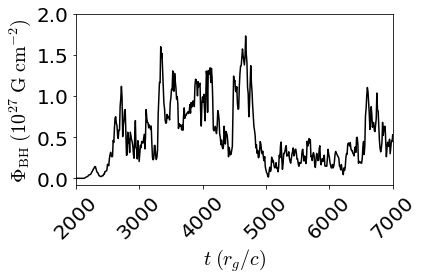

In [162]:
fs = np.array(fs)
fs_units = fs*B_unit*L_unit*L_unit
plt.plot(ts,fs_units*10**-27,color="black")
plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],rotation=45)
plt.yticks([0,0.5,1.0,1.5,2.0])
plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\Phi_\mathrm{BH}\;(10^{27}\;\mathrm{G}\;\mathrm{cm}^{-2})$")
plt.tight_layout()
plt.show()

savef=0
if (savef):
    plt.savefig("magflux.png", dpi=150)

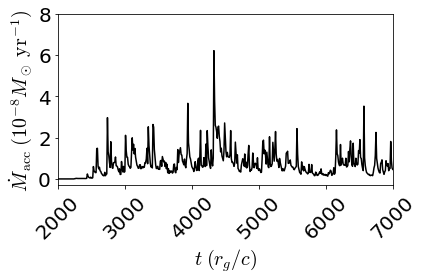

In [164]:
md = np.array(md)
md_units = md*M_unit/T_unit

plt.plot(ts,md_units*10**8/MSUN*YEAR,color="black")
plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],rotation=45)
plt.yticks([0,2,4,6,8])
plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\dot M_\mathrm{acc}\;(10^{-8}M_\odot\;\mathrm{yr}^{-1})$")
plt.tight_layout()
plt.show()

savef=0
if (savef):
    plt.savefig("mdotacc.png", dpi=150)

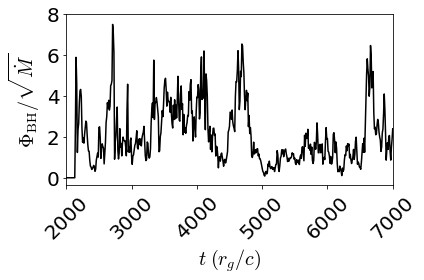

In [163]:
phiflux = fs/np.sqrt(md)
phiflux = np.array(phiflux)

plt.plot(ts,phiflux,color="black")
plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],rotation=45)
plt.yticks([0,2,4,6,8])
plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\Phi_\mathrm{BH}/\sqrt{\dot M}$")
plt.tight_layout()
plt.show()

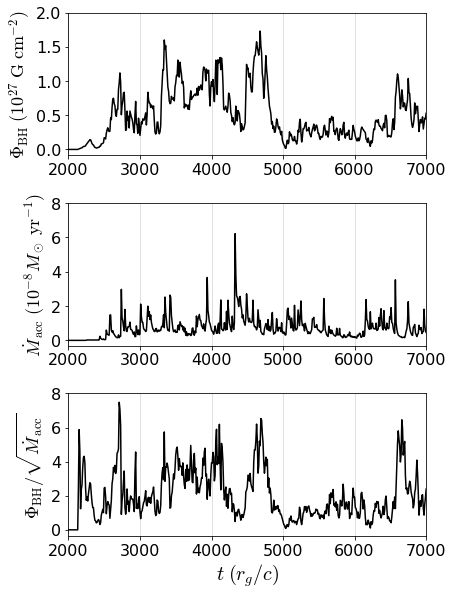

In [248]:
fs = np.array(fs)
fs_units = fs*B_unit*L_unit*L_unit
md = np.array(md)
md_units = md*M_unit/T_unit
phiflux = fs/np.sqrt(md)
phiflux = np.array(phiflux)

myfigname = "fluxes_2D.png"

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 8.4])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(3,1)

ax1 = plt.subplot(gs[0,0])
ax1.plot(ts,fs_units*10**-27,color="black")
_, max_ = plt.ylim()
#plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=16)
plt.yticks([0,0.5,1.0,1.5,2.0],fontsize=16)
plt.setp(ax1.get_xticklabels(), visible=True)
#plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\Phi_\mathrm{BH}\;(10^{27}\;\mathrm{G}\;\mathrm{cm}^{-2})$", fontsize=18)
plt.grid(axis='x', alpha=0.5)

ax2 = plt.subplot(gs[1,0], sharex=ax1)
ax2.plot(ts,md_units*10**8/MSUN*YEAR,color="black")
_, max_ = plt.ylim()
#plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)
#plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\dot M_\mathrm{acc}\;(10^{-8}M_\odot\;\mathrm{yr}^{-1})$", fontsize=18)
plt.setp(ax2.get_xticklabels(), visible=True)
plt.grid(axis='x', alpha=0.5)

ax3 = plt.subplot(gs[2,0], sharex=ax1)
ax3.plot(ts,phiflux,color="black")
_, max_ = plt.ylim()
plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=16)
plt.yticks([0,2,4,6,8],fontsize=16)
plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\Phi_\mathrm{BH}/\sqrt{\dot M_\mathrm{acc}}$", fontsize=18)
plt.grid(axis='x', alpha=0.5)

plt.tight_layout()

savef = 0
if (savef):
    plt.savefig(myfigname, dpi=150)

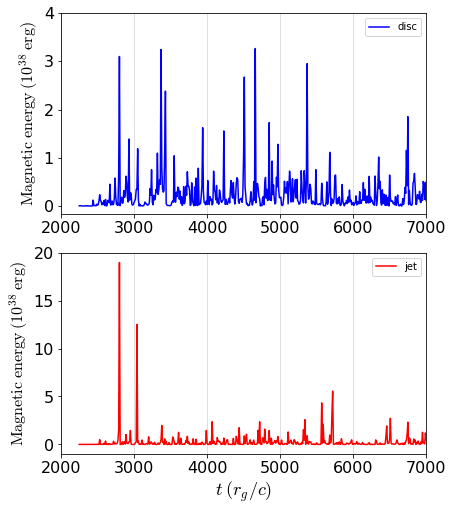

In [260]:
time = list(range(225, 701))
time = np.array(time)
time=10*time
myfigname = "magenergy_2D.png"
savef = 0

myfilename_d = "/work/gustavo/gyst/magenergy_2D_disc.dat"
mylabel_d = "disc"
mycolor_d = "blue"
myfilename_j = "/work/gustavo/gyst/magenergy_2D_jet.dat"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
magenext_d = mydata_d.values
magenext_d = np.array(magenext_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
magenext_j = mydata_j.values
magenext_j = np.array(magenext_j)
myfile_j.close()

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,1)

ax1 = plt.subplot(gs[0,0])
ax1.plot(time,magenext_d*B_unit*B_unit*L_unit*L_unit*L_unit/10**38, color=mycolor_d, label=mylabel_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$t\;(10r_g/c)$", fontsize=16)
plt.ylabel(r"$\mathrm{Magnetic\;energy}\;(10^{38}\;\mathrm{erg})$", fontsize=16)
#plt.ylabel(r"$B^2/8\pi\;(10^{38}\;\mathrm{erg})$", fontsize=18)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=16)
plt.setp(ax1.get_xticklabels(), visible=True)
plt.yticks([0,1,2,3,4],fontsize=16)
plt.grid(axis='x', alpha=0.5)
plt.legend()

ax2 = plt.subplot(gs[1,0], sharex=ax1)
ax2.plot(time,magenext_j*B_unit*B_unit*L_unit*L_unit*L_unit/10**38, color=mycolor_j, label=mylabel_j)
_, max_ = plt.ylim()
plt.xlim(2000,7000)
plt.xlabel(r"$t\;(r_g/c)$", fontsize=18)
plt.ylabel(r"$\mathrm{Magnetic\;energy}\;(10^{38}\;\mathrm{erg})$", fontsize=16)
#plt.ylabel(r"$B^2/8\pi\;(10^{38}\;\mathrm{erg})$", fontsize=18)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=16)
plt.yticks([0,5,10,15,20],fontsize=16)
plt.legend()
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()

savef=1
if (savef):
    plt.savefig(myfigname, dpi=150)

In [90]:
np.mean(magenext_j*B_unit*B_unit*L_unit*L_unit*L_unit)

3.0098080209545507e+37

In [91]:
np.mean(magenext_d*B_unit*B_unit*L_unit*L_unit*L_unit)

2.4258933295585765e+37

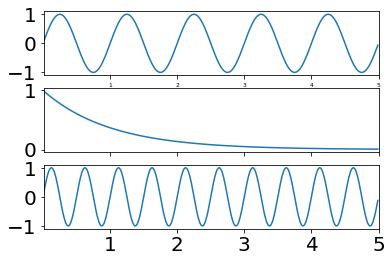

In [223]:

ttt = np.arange(0.01, 5.0, 0.01)
s1 = np.sin(2 * np.pi * ttt)
s2 = np.exp(-ttt)
s3 = np.sin(4 * np.pi * ttt)

ax1 = plt.subplot(311)
plt.plot(ttt, s1)
plt.setp(ax1.get_xticklabels(), fontsize=6)

# share x only
ax2 = plt.subplot(312, sharex=ax1)
plt.plot(ttt, s2)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)

# share x and y
ax3 = plt.subplot(313, sharex=ax1, sharey=ax1)
plt.plot(ttt, s3)
plt.xlim(0.01, 5.0)
plt.show()